In [35]:
import torch
import torch.nn as nn
import numpy as np  
import matplotlib.pyplot as plt

### Load pre-processed data

In [ ]:
from kma_preprocessing import RegionTransform
import gzip

with open('RDR_CMP_HSR_PUB_202208082000.bin.gz', mode='rb') as f:
    decompressed_bytes = gzip.decompress(f.read())
    img = np.frombuffer(decompressed_bytes, dtype=np.int16, offset=1024).astype(np.float32).reshape(2881,2305)

source_args = {'width': 2305, 'height': 2881, 'resolution': 500, 'center': (1681,1121)}
target_args = {'width': 256, 'height': 256, 'resolution': 4000}

rt = RegionTransform(source_args, target_args)
img = rt(img)

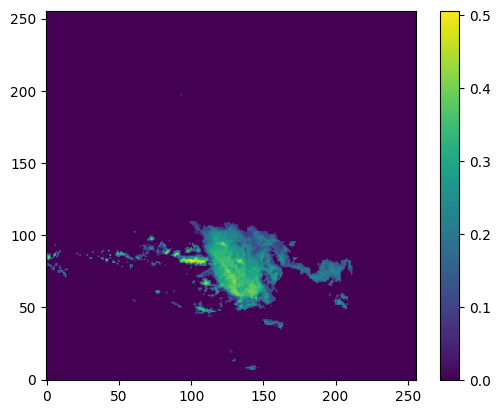

(256, 256)


In [37]:
plt.imshow(img, cmap='viridis') 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
print(img.shape) 

### Convert to rainfall intensity image

In [38]:
class ZR(nn.Module):
    def __init__(self, a=200, b=1.6):
        self.a = torch.tensor(a).float()
        self.b = torch.tensor(b).float()
    def to_dbz(self, img_rain):
        img_dbz = 10 * torch.log10(self.a * torch.pow(img_rain, self.b))
        img_dbz[img_dbz < 0] = 0     # set dbz=0 if rain is too small.
        return img_dbz
    def to_rain(self, img_dbz):
        img_rain = torch.pow(10, (0.1*img_dbz - torch.log10(self.a)) / self.b)
        return img_rain
    
img = torch.from_numpy(img).float()
zr_converter = ZR()
img_rain = zr_converter.to_rain(100 * img)

# Masking for non obeserved area
mask = np.load('data/kma/mask_2023.npy')
img_rain[mask==0] = np.nan

### Define colormap 
(source [KMA data wiki](https://datawiki.kma.go.kr/doku.php?id=%EB%A0%88%EC%9D%B4%EB%8D%94:%EA%B8%B0%EC%83%81%EB%A0%88%EC%9D%B4%EB%8D%94))

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def kma_colormap():
    cmap = ListedColormap(np.array([
        [250, 250, 250], [0, 200, 255], [0, 155, 245], [0, 74, 245],               
        [0, 255, 0], [0, 190, 0], [0, 140, 0], [0, 90, 0],                         
        [255, 255, 0], [255, 220, 31], [249, 205, 0], [224, 185, 0], [204, 170, 0], 
        [255, 102, 0], [255, 50, 0], [210, 0, 0], [180, 0, 0],                      
        [224, 169, 255], [201, 105, 255], [179, 41, 255], [147, 0, 228],            
        [179, 180, 222], [76, 78, 177], [0, 3, 144], [51, 51, 51]                  
    ]) / 255)
    cmap.set_bad([0, 0, 0, 0.3])
    bounds = np.array([
        0, 0.1, 0.5, 1, 
        2, 3, 4, 5,     
        6, 7, 8, 9, 10, 
        15, 20, 25, 30, 
        40, 50, 60, 70, 
        90, 110, 150    
    ])
    norm = BoundaryNorm(boundaries=bounds, ncolors=len(cmap.colors))
    return cmap, bounds, norm

kcmap, kbounds, knorm = kma_colormap()

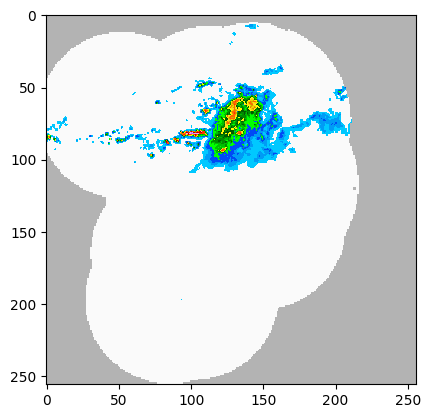

In [40]:
fig, ax = plt.subplots()
ax.imshow(img_rain.numpy(), cmap=kcmap, norm=knorm)

### Geographical map

(geo data source: [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/))

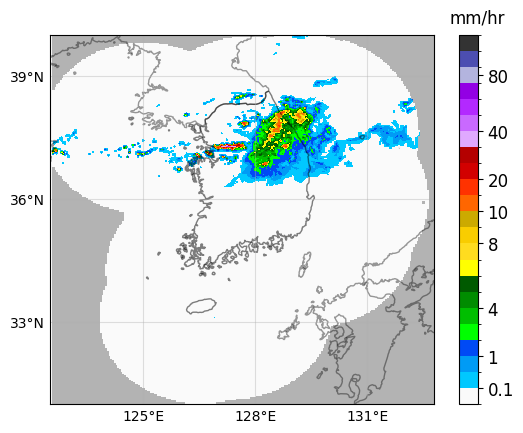

In [ ]:
import geopandas as gpd

world = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
south_korea = world[world.NAME == "South Korea"]
north_korea = world[world.NAME == "North Korea"]
china = world[world.NAME == "China"]
japan = world[world.NAME == "Japan"]

extent = [122.54572384823177, 134.47248320969067, 31.00876360780117, 40.24300283359723]

def config_korea(ax):
    south_korea.plot(ax=ax, color='none', edgecolor=(0, 0, 0, 0.5))  
    north_korea.plot(ax=ax, color='none', edgecolor=(0, 0, 0, 0.4))   
    china.plot(ax=ax, color='none', edgecolor=(0, 0, 0, 0.4))
    japan.plot(ax=ax, color='none', edgecolor=(0, 0, 0, 0.4))
    ax.grid(True, alpha=0.4)
    ax.set_xticks([125, 128, 131])
    ax.set_yticks([33, 36, 39])
    ax.set_xlim(122.5, 132.8)
    ax.set_ylim(31, 40.)
    ax.set_xticklabels(['125°E', '128°E', '131°E'])
    ax.set_yticklabels(['33°N', '36°N', '39°N'])
    ax.tick_params(axis='both', length=0) 
    ax.set_aspect(1.1)

fig, ax = plt.subplots()
im = ax.imshow(img_rain.numpy(), cmap=kcmap, norm=knorm, extent=extent)
config_korea(ax)

# add colorbar
cbar = fig.colorbar(im, ax=ax, ticks=[0.1, 1, 4, 8, 10, 20, 40, 80])
cbar.ax.set_yticklabels(['0.1', '1', '4', '8', '10', '20', '40', '80'], fontsize=12)
cbar.ax.text(1, 1.02, 'mm/hr', fontsize=12, ha='center', va='bottom', transform=cbar.ax.transAxes);